In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from YOLO.src.helper_functions.load_TFRecords import get_dataset
from YOLO.src.classes.Losses import YOLOConfidenceLoss, YOLOBoxLoss, YOLOClassLoss

from YOLO.src.helper_functions.model_output_utils import extract_boxes, draw_boundingboxes_on_image

import YOLO.GlobalValues as GlobalValues
GlobalValues.initialize()

In [2]:
train_filenames = ['train-000-of-010.tfrecord', 
                   'train-001-of-010.tfrecord',
                   'train-002-of-010.tfrecord',
                   'train-003-of-010.tfrecord',
                   'train-004-of-010.tfrecord',
                   'train-005-of-010.tfrecord',
                   'train-006-of-010.tfrecord',
                   'train-007-of-010.tfrecord',
                   'train-008-of-010.tfrecord',
                   'train-009-of-010.tfrecord',]

val_filenames = ['val-000-of-010.tfrecord', 
                 'val-001-of-010.tfrecord',
                 'val-002-of-010.tfrecord',
                 'val-003-of-010.tfrecord',
                 'val-004-of-010.tfrecord',
                 'val-005-of-010.tfrecord',
                 'val-006-of-010.tfrecord',
                 'val-007-of-010.tfrecord',
                 'val-008-of-010.tfrecord',
                 'val-009-of-010.tfrecord',]

train = get_dataset(train_filenames, augmentation=True)
val = get_dataset(val_filenames)

In [3]:
def load_model():
    INPUT_SHAPE = GlobalValues.FEATURE_EXTRACTOR_INPUT_SHAPE
    S = GlobalValues.S
    CLASSES = GlobalValues.CLASSES
    BOXES = GlobalValues.B
    
    base_model = GlobalValues.FEATURE_EXTRACTOR(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

    conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(base_model.output)
    batchnorm_1 = tf.keras.layers.BatchNormalization()(conv_1)
    activation_1 = tf.keras.layers.Activation('relu')(batchnorm_1)

    # OUTPUT LAYERS
    confidence_output = tf.keras.layers.Conv2D(BOXES, kernel_size=(1,1), padding='same', activation='sigmoid')(activation_1)
    xy_output = tf.keras.layers.Conv2D(BOXES*2, kernel_size=(1,1), padding='same', activation='sigmoid')(activation_1)
    wh_output = tf.keras.layers.Conv2D(BOXES*2, kernel_size=(1,1), padding='same', activation='tanh')(activation_1)

    class_output_layers = []
    for _ in range(BOXES):
        class_output_layers.append(tf.keras.layers.Conv2D(CLASSES, kernel_size=(1,1), padding='same', activation='softmax')(activation_1))

    output_layers = [confidence_output, xy_output, wh_output] + class_output_layers

    output = tf.keras.layers.Concatenate(axis=3)(output_layers)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    
    return model

model = load_model()
model.load_weights('model_checkpoints/MobileNet-Conv32L2001-(10-05-5).epoch02-loss408.92.hdf5')

# Testing. Currently No Model Trained for this

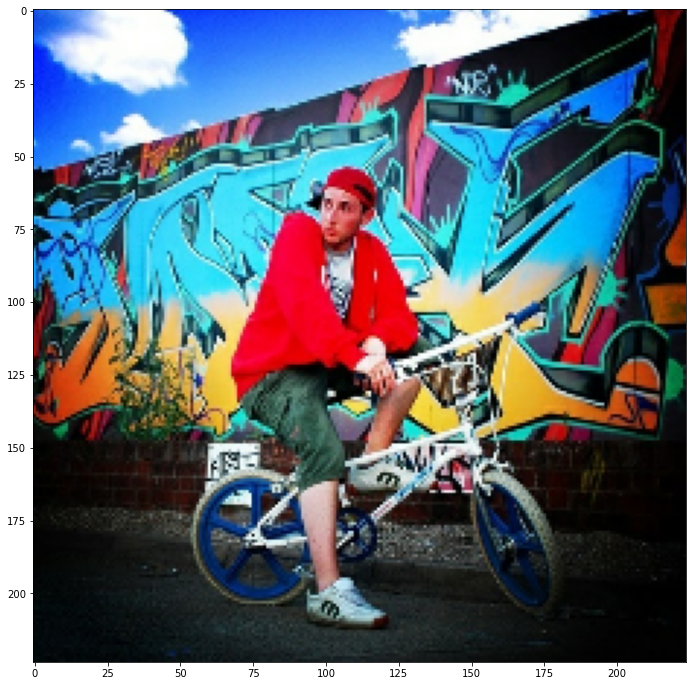

In [12]:
import numpy as np
plt.figure(figsize=(12,12))

for batch_x, batch_y in val.take(1):
    image = batch_x[0:1]
    label = batch_y[0:1]
    
    output = model.predict(image)[0]
    boxes = extract_boxes(output, confidence_threshold=0.2, B=1, C=2, S=7)

    image = ((image[0] + 1.) / 2.) * 255
    image = tf.cast(image, tf.uint8).numpy()
    
    draw_boundingboxes_on_image(image, boxes)
    plt.imshow(image)
